In [1]:
import sys
sys.path.append("../..")

import logging
logging.getLogger('tensorflow').disabled = True

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import h5py
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
file = h5py.File('BeamSamples.h5','r')
joint_samples = np.array(file['Samples/'],dtype=np.float32)
scaler = MinMaxScaler()
scaled_samples = scaler.fit_transform(joint_samples)
NUM_SAMPLES = joint_samples.shape[0]
BATCH_SIZE = 500
dataset = tf.data.Dataset.from_tensor_slices(scaled_samples)
dataset = dataset.shuffle(buffer_size=NUM_SAMPLES).batch(BATCH_SIZE)

In [3]:
from transport_nets.models import StackedFlow
from transport_nets.models import permute

OUTPUT_DIM = 9
NUM_LAYERS = 3
nvp_neurons = [100]
masks = NUM_LAYERS*[5]
permutations= []
perm = list(range(OUTPUT_DIM))
for _ in range(NUM_LAYERS):
    perm = tf.random.shuffle(perm)
    permutations.append(perm)
ffjord_neurons = [100]

stacked_flow = StackedFlow(output_dim=OUTPUT_DIM,
                 num_layers = NUM_LAYERS,
                 nvp_neurons = nvp_neurons,
                 masks = masks,
                 permutations = permutations,
                 ffjord_neurons = ffjord_neurons)
NUM_EPOCHS = 20
LR = 1e-3
opt = tf.optimizers.Adam(learning_rate=LR,epsilon=1e-8)
stacked_flow.compile(opt)
loss_history = stacked_flow.fit(dataset,NUM_EPOCHS)
stacked_flow.training_mode(False)

loss: -34.097 :  60%|██████    | 12/20 [07:53<05:15, 39.46s/it]


KeyboardInterrupt: 

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(loss_history, sigma=4)
plt.plot(loss_history,'b')
plt.plot(ysmoothed, color = 'r')
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')

<Figure size 1080x1080 with 0 Axes>

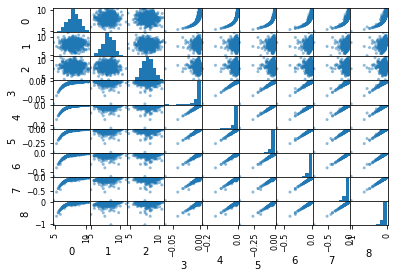

<Figure size 1080x1080 with 0 Axes>

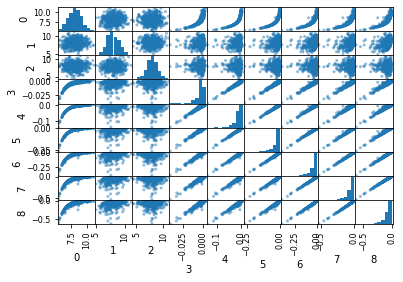

In [5]:
plt.figure(figsize=(15,15))
scatter_matrix(pd.DataFrame(joint_samples[::100,:]))
plt.show()

fig = plt.figure(figsize=(15,15))
x_forward = scaler.inverse_transform(stacked_flow.sample(500).numpy())
scatter_matrix(pd.DataFrame(x_forward))
plt.savefig('images/Stacked-Flow-scatter-matrix.png')
plt.show()

In [6]:
from transport_nets.mcmc import MetropolisHastings
from transport_nets.mcmc import model_log_prob
num_params = 3
test_values = np.array(file['TestValues'],dtype=np.float32)
m_y_scaled = scaler.transform(np.reshape(test_values,(1,-1)))
y_obs = m_y_scaled[0,num_params:]
init_val = tf.constant([0.7,0.5,0.3])
b = tf.constant(0.1,tf.float32)
niters = 3000
log_prob_fn = model_log_prob(stacked_flow,y_given=y_obs)
samples,acc_rate,time_total = MetropolisHastings(init_val,b,niters,log_prob_fn)

100%|██████████| 3000/3000 [06:57<00:00,  7.19it/s]


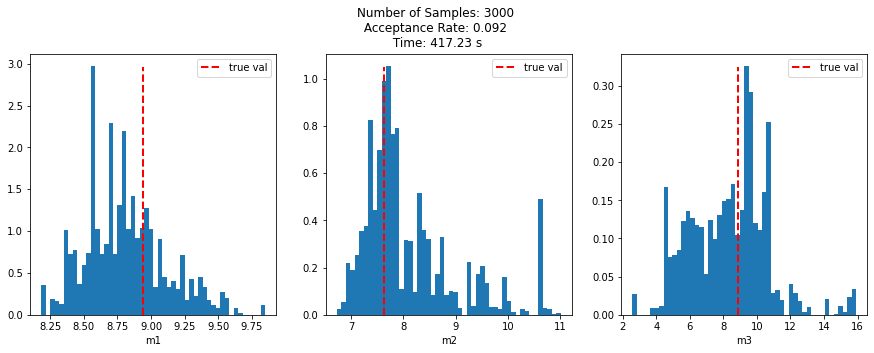

In [7]:
# unscaling sampled parameters (m1,m2,m3)
data_min = scaler.data_min_[:num_params]
data_max = scaler.data_max_[:num_params]
scale = scaler.scale_[:num_params]
samples_unscaled = samples*(data_max-data_min) + data_min

fig, axs = plt.subplots(1,3,figsize=(15,5))
m1,m2,m3 = tuple(test_values[:num_params])

axs[0].hist(samples_unscaled[:,0],50,density=True)
axs[0].axvline(m1,ymax=0.95,c='r',ls='--',lw=2.0,label='true val')
axs[0].set_xlabel('m1')
axs[0].legend()

axs[1].hist(samples_unscaled[:,1],50,density=True)
axs[1].axvline(m2,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[1].set_xlabel('m2')
axs[1].legend()

axs[2].hist(samples_unscaled[:,2],50,density=True)
axs[2].axvline(m3,ymax=0.95,c='r',lw=2.0,ls='--',label='true val')
axs[2].set_xlabel('m3')
axs[2].legend()

plt.suptitle('Number of Samples: %d\n Acceptance Rate: %0.3f \n Time: %0.2f s'%(niters,acc_rate,time_total))
plt.subplots_adjust(top=0.85)

plt.savefig('images/FFJORD-MH-Euler_Beam.png')